In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import tensorboard as tb
sns.set_theme()

In [2]:
reward_df = pd.read_csv('ddqn_reward_training.csv')

In [3]:
reward_df['Frames'] = 950
reward_df['Frames accum.'] = reward_df['Frames'].cumsum()

In [4]:
n = 10
reward_df[f'Running_{n}'] = reward_df['Step'] // n
reward_std = reward_df['Value'].rolling(n).std()
reward_df[f'mean_{n}'] = reward_df['Value'].rolling(n).mean()
reward_df['lower_std'] = reward_df[f'mean_{n}'] - reward_std
reward_df['upper_std'] = reward_df[f'mean_{n}'] + reward_std
reward_df['Wall time'] = pd.to_datetime(reward_df['Wall time'], unit='s')
reward_df['Relative time'] = reward_df['Wall time'] - reward_df['Wall time'][0]

In [5]:
alpha=0.1
reward_df['Value_ema'] = reward_df['Value'].ewm(alpha=alpha).mean()

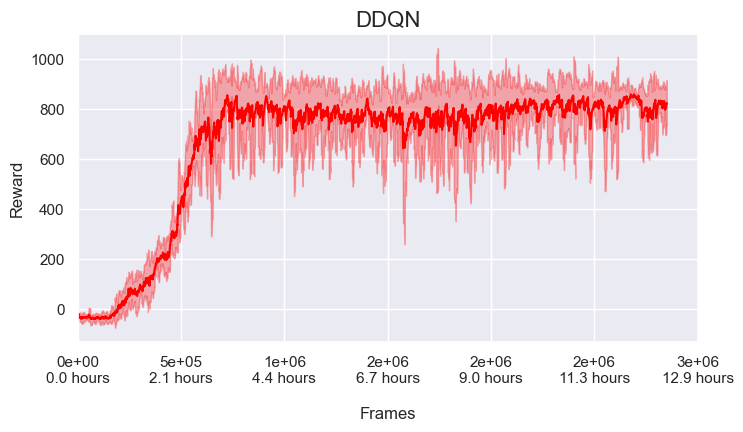

In [31]:
line_color = 'red'
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title('DDQN', fontdict={'fontsize':16})
ax.set_ylabel('Reward', fontdict={'fontsize':12})
ax.set_xlabel('Frames', fontdict={'fontsize':12})
ax.set_xlim(xmin=0,xmax=3e6)
ax.fill_between(reward_df['Frames accum.'], reward_df['lower_std'], reward_df['upper_std'], alpha=.3, color=line_color) # label='std of reward'
sns.lineplot(x=reward_df['Frames accum.'], y=reward_df['Value_ema'], color=line_color) # label='Reward EMA '+ r'($\alpha$={0})'.format(alpha)
# ax.plot(reward_df['Value_ema'], color=line_color, label=f'Reward EMA (alpha={alpha})')
new_ticks = []
for x in ax.get_xticks().tolist():
    txt = int(x)
    if x >= 0:
        nearest_idx = min(reward_df['Frames accum.'].searchsorted(x), len(reward_df)-1)
        hours = reward_df['Relative time'].iloc[nearest_idx].total_seconds()/3600
        txt = f'{txt:.0e}' + '\n' + f"{hours:.1f}" + ' hours\n'
    new_ticks.append(txt)
ax.set_xticks(ax.get_xticks().tolist())
ax.set_xticklabels(new_ticks)
# ax.legend()
plt.show()

## Remove idle time, as the training was frozen there

<AxesSubplot: title={'center': 'with idle point'}>

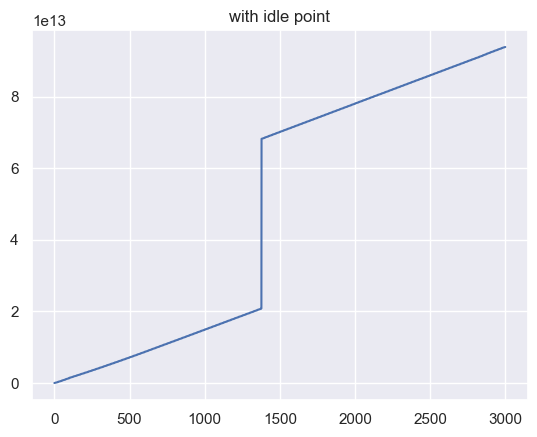

In [7]:
reward_df['Relative time'].plot(title="with idle point")

In [8]:
reward_df['Relative time'].diff().max(), reward_df['Relative time'].diff().argmax()

(Timedelta('0 days 13:09:01.022315008'), 1378)

In [9]:
# remove the idle duration + avg. diff until idle point to every relative time measure after the idle point happens
idle_time = reward_df['Relative time'].diff()[1378] - reward_df['Relative time'].diff()[:1378].mean()
# adjust time
reward_df['Relative time'][1378:] = reward_df['Relative time'][1378:] - idle_time

C:\Users\test\AppData\Local\Temp\ipykernel_11024\2145613199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reward_df['Relative time'][1378:] = reward_df['Relative time'][1378:] - idle_time


<AxesSubplot: title={'center': 'Removed idle point'}>

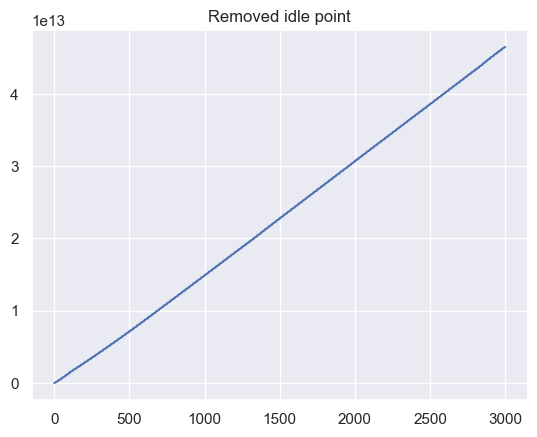

In [10]:
reward_df['Relative time'].plot(title="Removed idle point")